**1.1 Moving Average Strategy**

This algorithm is a short-term trading strategy based off the moving average indicator. Utilizing moving average compares the velocity of price movement between distinct periods of time. If the moving average of a period with the shorter time window is greater than the period with the larger window, this indicates that the price is currently experiencing an upwards trend which should incentivize buying pressure.  

In [73]:
#dependencies
import numpy as np
import yfinance as yf
import pandas as pd

In [74]:
#retrieving market data
tesla = yf.Ticker("TSLA")
data = tesla.history(interval = "1wk", period = "6mo")
print(data)

                                 Open        High         Low       Close  \
Date                                                                        
2022-07-25 00:00:00-04:00  272.216675  298.320007  256.263336  297.149994   
2022-08-01 00:00:00-04:00  301.276672  313.606659  285.543335  288.170013   
2022-08-08 00:00:00-04:00  295.000000  305.200012  279.353333  300.029999   
2022-08-15 00:00:00-04:00  301.786682  314.666656  292.500000  296.666656   
2022-08-22 00:00:00-04:00  291.913330  303.646667  286.296661  288.089996   
2022-08-29 00:00:00-04:00  282.829987  288.480011  266.149994  270.209991   
2022-09-05 00:00:00-04:00  272.679993  299.850006  265.739990  299.679993   
2022-09-12 00:00:00-04:00  300.720001  309.119995  290.399994  303.350006   
2022-09-19 00:00:00-04:00  300.089996  313.799988  272.820007  275.329987   
2022-09-26 00:00:00-04:00  271.829987  289.000000  262.470001  265.250000   
2022-10-03 00:00:00-04:00  254.500000  257.500000  222.020004  223.070007   

**1.2 Calulation of the moving average indicators**

In [75]:
#calculate 3 week and 10 week moving averages based on closing prices
m_3 = data['Close'].rolling(window = 3).mean()
m_10 = data['Close'].rolling(window = 10).mean()

#displays the last moving average values for each interval
print(m_3[-1])
print(m_10[-1])



133.41666412353516
146.66399917602538


In [76]:
#If the 3 week moving average is greater than the 10 week, Tesla stock in trending up
if m_3[-1] > m_10[-1]:
    print("Tesla stock is trending up")

#If the 10 week moving average is greater than the 3 week, Tesla stock is trending down
else:
    print("Tesla stock is trending down")


Tesla stock is trending down


**2.1 Backtesting Rules**

*Testing Structure*
- Create copy of data list called new_data with a 6 month period
- A loop is created where all the backtesting functionality is going to be written
- This loop splices the historical market data into a 4 week segment and continues to add 4 weeks of data up until 6 months
- Then the moving average function is applied on this data's last closing date (so it is testing the data backwards NOT forwards)
- The porfolio is going to start out with 0 stock and $100,000 to invest

*Case 1: No stock*
- If the order is to sell and you have no stock don't do anything
- If the order is to buy and you have no stock find the stock price and subtract that from $100,000 (portfolio amount) and increment the number of stock you have by 1 (Log the transaction in console: BUY 1 $TSLA stock @ [stockprice])

*Case 2: With Stock*
- If the order is to sell and you have stock, find the stock price and add it to the portfolio amount (Log the transaction in console: SELL 1 $TSLA stock @ [stockprice])
- If the order is to buy and you have stock, find the stock price and subtract it from the portfolio amount (Log the transaction in console: SELL 1 $TSLA stock @ [stockprice])

*Results*
- The results are going to record realized and unrealized P/L
- Realized P/L = The remaining portfolio amount - 100,000
- Unrealized P/L = The remaining portfolio amount + (# of stocks * most recent stock price) - 100,000


In [77]:
#backtest
def backtesting(max_weeks, additional_weeks):

    #initializing variables
    start = 0
    end = 0
    stocks = 0
    portfolio = 100000
    time = []
    price = []
    position = []
    #the end of the data is up to a week maximum which represents the 6 month period
    while end <= max_weeks:
        new_data = tesla.history(interval = "1wk", period = "6mo")
        #additional weeks of data are added on every loop
        end = end + additional_weeks
        new_data = new_data[:end]
        m_1 = new_data['Close'].rolling(window = 1).mean()
        m_2 = new_data['Close'].rolling(window = 2).mean()
        #to drop null values due to yahoo finance's bad API(lol)
        m_1 = m_1.dropna()
        m_2 = m_2.dropna()

        if m_1[-1] > m_2[-1]:
            if stocks > 0:
                stocks = stocks - 1
                portfolio = portfolio + new_data['Close'][-1]
                time.append(end)
                price.append(new_data['Close'][-1])
                position.append(False)
                print("Sold Tesla Stock @ $", new_data['Close'][-1])
        if m_1[-1] < m_2[-1]:
            stocks = stocks + 1
            portfolio = portfolio - (new_data['Close'][-1])
            time.append(end)
            price.append(new_data['Close'][-1])
            position.append(True)
            print("Bought Tesla Stock @ $", new_data['Close'][-1])
        
    print("Realized P/L: ", portfolio - 100000, "\n")
    print("Unrealized P/L: ", (portfolio + (new_data['Close'][-1] * stocks)) - 100000)
    return time, price, position
#26 maximum weeks, with 4 additional weeks
time, price, position = backtesting(26,4)

Bought Tesla Stock @ $ 296.6666564941406
Sold Tesla Stock @ $ 303.3500061035156
Bought Tesla Stock @ $ 204.99000549316406
Bought Tesla Stock @ $ 195.97000122070312
Bought Tesla Stock @ $ 179.0500030517578
Bought Tesla Stock @ $ 113.05999755859375
Sold Tesla Stock @ $ 144.42999267578125
Realized P/L:  -541.9566650390625 

Unrealized P/L:  -108.66668701171875


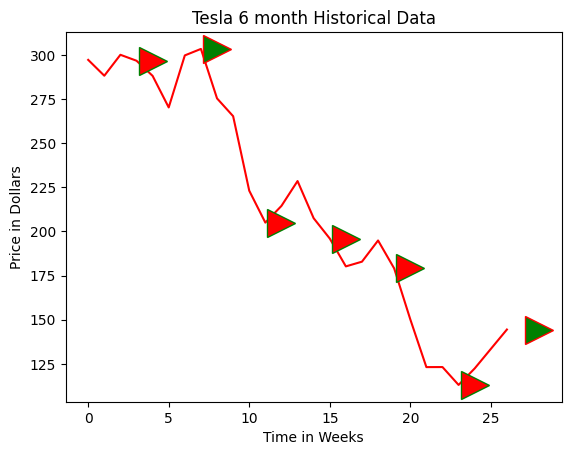

In [78]:
#creating the chart
import matplotlib.pyplot as plt
historical_data = tesla.history(interval = "1wk", period = "6mo")
x = np.arange(0, 27)
y = []

for i in range(0,27):
    y.append(historical_data['Close'][i])

# plotting
plt.title("Tesla 6 month Historical Data")
plt.xlabel("Time in Weeks")
plt.ylabel("Price in Dollars")
plt.plot(x, y, color ="red")

for unit in range(0, len(time)):
    if position[unit]:
        plt.plot(time[unit], price[unit], color ="red", marker=">", markersize=20, markeredgecolor="green",
        markerfacecolor="red")
    if not position[unit]:
        plt.plot(time[unit], price[unit], color ="green", marker=">", markersize=20, markeredgecolor="red",
        markerfacecolor="green")
plt.show()

**2.2 Analysis**

- The chart presented above is the 6 month historical data for Tesla stock. The red arrows represent the positions where a share is bought while the green arrows represent the positions where the bot has sold shares. 
- Something I've noticed with the trading model is that it tends to buy the dip while selling the upwards trend almost a bit too well. It overfits the historical data instead of estimating the optimal minimum to buy a share at its lowest price.
- This algorithm has the potential to become profitable if it is able to estimate the optimal prices to buy and sell an asset.